<a href="https://colab.research.google.com/github/acoiman/pdt/blob/main/asthma_mortality/notebooks/colab/05_Asthma_Mortality_BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥 Burned Area (BA) Data

In this notebook, we will calculate the annual burned areas aggregated and normalized by the surface area of each department. From 2001 to 2020 we will use the MODIS Fire_cci Burned Area pixel product version 5.1 (FireCCI51)<sup>1</sup> available on Google Earth Engine (GEE) at https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1. From 2021 to 2022 we will use the same dataset avilable on the Centre for Environmental Data Analysis (CEDA) at https://catalogue.ceda.ac.uk/uuid/58f00d8814064b79a0c49662ad3af537/

##📦 Import Required Libraries

In [61]:
# geospatial data handling
import geopandas as gpd
import geemap
import ee
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.mask import mask
import rasterstats
from shapely.geometry import mapping

# map visualization
import folium
import geemap.foliumap as geemap_folium

# array and data frame handling
import numpy as np
import pandas as pd

# other libraries
import os
import zipfile
import shutil
import requests
import tarfile
import subprocess
from datetime import datetime
from typing import Union, List
from itables import init_notebook_mode

## 🌍 Connect to Google Earth Engine (GEE)

In [ ]:
# trigger the authentication flow
ee.Authenticate()

True

In [ ]:
# initialize the library.
ee.Initialize(project='ee-pdt')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


## ✂️ Calculating BA data per departaments

To calculate the burned area (BA) per department, we will begin by processing data from the year 2001 as a step-by-step example. Next, we will develop a function in Google Earth Engine (GEE) to compute the normalized burned area (per 1,000 km²) for the period 2001–2020. Finally, we will calculate the normalized burned area for the years 2021–2022 using Python geospatial libraries and data obtained from CEDA.

In [4]:
# change to my computer home directory
%cd work

/home/jovyan/work


### Extract and downscale BA image (2001)

In [ ]:
# Load FireCCI burned area data for 2001
dataset = ee.ImageCollection('ESA/CCI/FireCCI/5_1') \
    .filterDate('2001-01-01', '2001-12-31') \
    .select('BurnDate')

# Binary burned area (1 = burned, 0 = not burned)
dataset = dataset.map(lambda img: img.gt(0).selfMask())

# Max burn date per pixel
max_ba = dataset.max()

# Load Argentina polygon
argentina = ee.FeatureCollection('projects/ee-pdt/assets/argentina/ar_poly')

# Clip image to Argentina
max_ba_arg = max_ba.clip(argentina)

# Reduce resolution 1 km and set a valid default projection (MODIS-like: 1 km in EPSG:4326)
max_ba_arg_1km = max_ba_arg \
    .setDefaultProjection(crs='EPSG:4326', scale=1000) \
    .reduceResolution(reducer=ee.Reducer.max(), maxPixels=1024) \
    .reproject(crs='EPSG:4326', scale=1000)

In [142]:
# Visualization: red = burned (1), white = unburned (0)
ba_vis = {
    'min': 0,
    'max': 1,
    'palette': ['ffffff', 'ff0000']
}

# Get EE TileLayer URL
map_id_dict = ee.Image(max_ba_arg_1km).getMapId(ba_vis)

# Create a Folium map centered on Argentina
m = folium.Map(location=[-38.4, -63.6], zoom_start=4)

# Add the EE burned area layer
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Map Data © Google Earth Engine',
    name='Burned Area 2001 - Argentina',
    overlay=True,
    control=True
).add_to(m)

# Convert Argentina FeatureCollection to GeoJSON
argentina_geojson = geemap.ee_to_geojson(argentina)

# Add Argentina boundary to map
folium.GeoJson(
    argentina_geojson,
    name='Argentina Boundary',
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'black',
        'weight': 2
    }
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

### Calculate & Normalize Burned Area in 2001

In [72]:
# Convert pixel area from square meters  into square kilometers
pixel_area = ee.Image.pixelArea().divide(1e6)  # convert m² to km²
burned_area_km2 = max_ba_arg_1km.multiply(pixel_area)

In [74]:
# Load department polygons
departments = ee.FeatureCollection('projects/ee-pdt/assets/tma/tma_pm25_2001_2022')

In [75]:
# Calculate total burned area per department
def compute_burned_area(feat):
    stats = burned_area_km2.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=feat.geometry(),
        scale=1000,
        maxPixels=1e13
    )
    ba_km2 = ee.Number(stats.get('BurnDate'))
    dept_area = feat.geometry().area().divide(1e6)  # depatment area km²
    normalized_ba = ba_km2.divide(dept_area)  # normalized (department area) burned area
    normalized_ba = normalized_ba.multiply(1000)  # normalized burned area per 1000 km²
    normalized_ba = normalized_ba.multiply(100).round().divide(100) # Round to 2 decimal places
    return feat.set({
        # 'BA_2001': ba_km2,
        # 'DA_2001': dept_area,
        'NBA_2001': normalized_ba
    })

In [76]:
# Map the function over departments
departments_ba = departments.map(compute_burned_area)

In [77]:
# Convert to GeoDataFrame
gdf = geemap.ee_to_gdf(departments_ba)


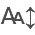

IDDPTO  NBA_2001
0  06014      6.45
1  06077      0.00
2  06154      0.01
3  06161      0.00
4  06168      0.00

In [95]:
# visualize IDDPTO and NBA_2001 (Normalized Burn Area 2001 per 1000 km2)
selected_columns = gdf[['IDDPTO','NBA_2001']]
init_notebook_mode(all_interactive=False)
selected_columns.head()


### Compute the normalized burned area (per 1000 km²) from 2001 to 2020

In [129]:
def compute_normalized_burned_area(year: Union[int, str], departments_fc: ee.FeatureCollection, country_fc: ee.FeatureCollection) -> ee.FeatureCollection:
    """
    Compute the normalized burned area (per 1000 km²) for a given year and return it as a FeatureCollection.
    """

    # Ensure the year is a string (needed for building date strings)
    year = str(year)

    # Print a message for tracking which year is being processed
    print(f"Processing year {year}...")

    # Load the FireCCI dataset for the selected year, select the 'BurnDate' band,
    # and mask out unburned pixels (set values > 0 to 1)
    dataset = ee.ImageCollection('ESA/CCI/FireCCI/5_1') \
        .filterDate(f'{year}-01-01', f'{year}-12-31') \
        .select('BurnDate') \
        .map(lambda img: img.gt(0).selfMask())

    # Take the maximum burn date value per pixel (this creates a binary mask: burned = 1)
    max_ba = dataset.max()

    # Clip the burned area image to the boundaries of the country (e.g., Argentina)
    max_ba_arg = max_ba.clip(country_fc)

    # Set default CRS and scale
    # Aggregate finer-resolution pixels
    max_ba_arg_1km = max_ba_arg \
        .setDefaultProjection(crs='EPSG:4326', scale=1000) \
        .reduceResolution(reducer=ee.Reducer.max(), maxPixels=1024) \
        .reproject(crs='EPSG:4326', scale=1000)# Reproject to enforce 1 km resolution

    # Create an image where each pixel represents its area in km²
    pixel_area = ee.Image.pixelArea().divide(1e6)

    # Multiply the binary burned area mask by the pixel area to get burned area in km²
    burned_area_km2 = max_ba_arg_1km.multiply(pixel_area)

    # Define a nested function to compute burned area stats for each department
    def compute_ba(feat):
        # Use reduceRegion to sum burned area values within each department
        stats = burned_area_km2.reduceRegion(
            reducer=ee.Reducer.sum(),        # Sum of burned area
            geometry=feat.geometry(),        # Department geometry
            scale=1000,                      # Analysis resolution (1 km)
            maxPixels=1e13                   # High limit for pixel processing
        )
        # Extract total burned area in km²
        ba_km2 = ee.Number(stats.get('BurnDate'))

        # Compute the area of the department in km²
        dept_area = feat.geometry().area().divide(1e6)

        # Normalize the burned area per 1000 km² of department area
        normalized_ba = ba_km2.divide(dept_area).multiply(1000)

        # Round the result to 2 decimal places
        normalized_ba = normalized_ba.multiply(100).round().divide(100)

        # Add the normalized value as a new property (e.g., NBA_2001)
        return feat.set({f'NBA_{year}': normalized_ba})

    # Apply the function to all department features
    return departments_fc.map(compute_ba)

In [130]:
# Load input feature collections
argentina = ee.FeatureCollection('projects/ee-pdt/assets/argentina/ar_poly') # Argentina boundaries
# dataset with mortality rate, Pm2.5, population and departments
departments = ee.FeatureCollection('projects/ee-pdt/assets/tma/tma_pm25_2001_2022')

In [131]:

# Initialize an empty GeoDataFrame
combined_gdf = None

In [ ]:
# Loop over the range of years from 2001 to 2020 (inclusive)
for year in range(2001, 2021):

    # Call the function to compute normalized burned area (NBA) for the current year
    # using the departments and Argentina boundary FeatureCollections
    result_fc = compute_normalized_burned_area(year, departments, argentina)

    # Convert the resulting Earth Engine FeatureCollection to a GeoDataFrame
    result_gdf = geemap.ee_to_gdf(result_fc)

    # If this is the first year, initialize the combined GeoDataFrame
    if combined_gdf is None:
        combined_gdf = result_gdf
    else:
        # For subsequent years, merge the new year’s NBA column into the combined GeoDataFrame
        # We keep only the geometry and NBA column for merging
        combined_gdf = combined_gdf.merge(
            result_gdf[[result_gdf.geometry.name, f'NBA_{year}']],  # keep geometry and current year column
            on=combined_gdf.geometry.name  # merge based on geometry
        )


In [ ]:
# Display the first few rows of the DataFrame
init_notebook_mode(all_interactive=True)
combined_gdf.head()


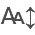

IDDPTO  NBA_2001
0  06014      6.45
1  06077      0.00
2  06154      0.01
3  06161      0.00
4  06168      0.00

In [134]:
# visualize IDDPTO and NBA_2001 to check results
selected_columns = combined_gdf[['IDDPTO','NBA_2001']]
init_notebook_mode(all_interactive=False)
selected_columns.head()

In [137]:
# Save the GeoDataFrame to a GeoPackage file
combined_gdf.to_file("pdt/asthma_mortality/data/gpkg/tma_pm25_ba_2001_2020.gpkg", driver="GPKG")


### Compute the normalized burned area (per 1000 km²) from 2021 to 2022

#### 2021

In [132]:
# Load Argentina boundary
argentina = gpd.read_file('pdt/asthma_mortality/data/shp/ar_poly.shp')  # Replace with your actual path
argentina = argentina.to_crs("EPSG:4326")  # Ensure CRS matches raster data

In [133]:
# Define months
months = [f'{i:02d}' for i in range(1, 13)]

In [134]:
# Base URL
base_url = 'https://data.ceda.ac.uk/neodc/esacci/fire/data/burned_area/MODIS/pixel/v5.1/compressed/2021/'

##### Downloading images

In [135]:
# Define directories
download_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/downloads/2021'
os.makedirs(download_dir, exist_ok=True)

In [ ]:

for month in months:
    filename = f'2021{month}01-ESACCI-L3S_FIRE-BA-MODIS-AREA_2-fv5.1.tar.gz'
    url = base_url + filename
    download_path = os.path.join(download_dir, filename)

    # Download the file
    print(f'Downloading {filename}...')
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(download_path, 'wb') as f:
            f.write(response.raw.read())
    else:
        print(f'Failed to download {filename}')

##### Extracting, clipping, and binarize images

In [137]:
# Define directories
extract_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/extracted/2021'
os.makedirs(extract_dir, exist_ok=True)

processed_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/processed/2021'
os.makedirs(processed_dir, exist_ok=True)

In [138]:
# Initialize list to store monthly arrays
monthly_arrays = []

In [ ]:
# extracting images
for month in months:
    filename = f'2021{month}01-ESACCI-L3S_FIRE-BA-MODIS-AREA_2-fv5.1.tar.gz'
    # Extract the JD.tif file
    print(f'Extracting JD.tif from {filename}...')
    download_path = os.path.join(download_dir, filename)
    with tarfile.open(download_path, 'r:gz') as tar:
        jd_tif = [m for m in tar.getmembers() if m.name.endswith('JD.tif')]
        if jd_tif:
            tar.extract(jd_tif[0], path=extract_dir)
            jd_path = os.path.join(extract_dir, jd_tif[0].name)
        else:
            print(f'JD.tif not found in {filename}')
            continue

    # Clip to Argentina boundary
    print(f'Clipping {jd_path} to Argentina boundary...')
    with rasterio.open(jd_path) as src:
      out_image, out_transform = mask(src, argentina.geometry.map(mapping), crop=True)
      out_meta = src.meta.copy()

      # Update basic output metadata (shape and transform)
      out_meta.update({
          "driver": "GTiff",
          "height": out_image.shape[1],
          "width": out_image.shape[2],
          "transform": out_transform
      })

      # Add compression and dtype
      out_meta.update({
          "dtype": "uint8",       # To store binary image
          "compress": "lzw"       # Apply LZW compression
      })


    # Convert to binary burned area (1 = burned, 0 = not burned)
    print(f'Converting {jd_path} to binary burned area...')
    binary_array = np.where(out_image[0] > 0, 1, 0).astype(np.uint8)
    monthly_arrays.append(binary_array)

    # Save the binary raster
    binary_path = os.path.join(processed_dir, f'binary_{month}.tif')
    with rasterio.open(binary_path, 'w', **out_meta) as dest:
        dest.write(binary_array, 1)

##### Calculate BA annual image

In [140]:
# Aggregate monthly data into annual image
annual_array = np.sum(monthly_arrays, axis=0)
annual_binary = np.where(annual_array > 0, 1, 0)

In [141]:
# Save the annual binary raster
annual_path = os.path.join("pdt/asthma_mortality/data/raster/Fire_cci", 'annual_burned_area_2021.tif')
with rasterio.open(annual_path, 'w', **out_meta) as dest:
    dest.write(annual_binary, 1)

#####  Downscale BA image (2021)

In [142]:
# Path to input and output rasters
input_path = "pdt/asthma_mortality/data/raster/Fire_cci/annual_burned_area_2021.tif"
output_path = "pdt/asthma_mortality/data/raster/Fire_cci/burned_area_2021_binary_1km.tif"

In [143]:
# Desired resolution in degrees (~1 km at equator)
target_resolution = 0.008333

In [144]:
with rasterio.open(input_path) as src:
    # Read metadata
    src_transform = src.transform
    src_crs = src.crs
    src_width = src.width
    src_height = src.height
    src_bounds = src.bounds

    # Calculate new transform and dimensions for 1 km resolution
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, src_crs, src.width, src.height, *src.bounds, resolution=target_resolution
    )

    # Prepare destination metadata
    dst_meta = src.meta.copy()
    dst_meta.update({
        "driver": "GTiff",
        "height": dst_height,
        "width": dst_width,
        "transform": dst_transform,
        "compress": "lzw",
        "dtype": "uint8"
    })

    # Create output raster
    with rasterio.open(output_path, "w", **dst_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src_crs,
                resampling=Resampling.max  # Preserve burned area pixels
            )


##### Compute the Normalized Burned Area (NBA) 2021

In [145]:
# Load departments' GPKG
gdf = gpd.read_file("pdt/asthma_mortality/data/gpkg/tma_pm25_ba_2001_2020.gpkg")

In [146]:
# Load 1 km binary burned area raster
raster_path = "pdt/asthma_mortality/data/raster/Fire_cci/burned_area_2021_binary_1km.tif"

In [147]:
# Get pixel area in km² (1x1 km = 1 km² for 1 km resolution)
pixel_area_km2 = 1.0

In [148]:
# Zonal statistics: sum burned pixels (value == 1) per polygon
zs = rasterstats.zonal_stats(
    vectors=gdf,
    raster=raster_path,
    stats=["sum"],
    nodata=0,
    geojson_out=False
)

In [149]:
# Extract burned pixel counts
burned_pixels = [item['sum'] if item['sum'] is not None else 0 for item in zs]

In [150]:
# Calculate burned area in km²
burned_area_km2 = np.array(burned_pixels) * pixel_area_km2

In [151]:
# Reproject to a projected CRS
gdf = gdf.to_crs(epsg=6933)

In [152]:
# Compute department area in km²
gdf["dept_area_km2"] = gdf.geometry.area / 1e6

In [153]:
# Compute NBA_2021 (burned area per 1000 km² of department)
gdf["NBA_2021"] = np.round((burned_area_km2 / gdf["dept_area_km2"]) * 1000, 2)

In [154]:
# Drop dept_area if not needed
gdf.drop(columns="dept_area_km2", inplace=True)

In [155]:
# Reproject back to 4326
gdf = gdf.to_crs(epsg=4326)

In [ ]:
init_notebook_mode(all_interactive=True)
gdf.head()


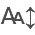

count    511.000000
mean      19.782446
std       48.677074
min        0.000000
25%        0.000000
50%        2.410000
75%       15.600000
max      398.420000
Name: NBA_2021, dtype: float64

In [157]:
init_notebook_mode(all_interactive=False)
gdf['NBA_2021'].describe()

In [158]:
# Save the GeoDataFrame to a GeoPackage file
gdf.to_file("pdt/asthma_mortality/data/gpkg/tma_pm25_ba_2001_2021.gpkg", driver="GPKG")

##### Remove temporal folders

In [60]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/downloads"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")


Folder 'pdt/asthma_mortality/data/raster/Fire_cci/downloads' removed successfully.


In [62]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/extracted"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")

Folder 'pdt/asthma_mortality/data/raster/Fire_cci/extracted' removed successfully.


In [63]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/processed"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")

Folder 'pdt/asthma_mortality/data/raster/Fire_cci/processed' removed successfully.


#### 2022

In [159]:
# Load Argentina boundary
argentina = gpd.read_file('pdt/asthma_mortality/data/shp/ar_poly.shp')  # Replace with your actual path
argentina = argentina.to_crs("EPSG:4326")  # Ensure CRS matches raster data

In [160]:
# Define months
months = [f'{i:02d}' for i in range(1, 13)]

In [161]:
# Base URL
base_url = 'https://data.ceda.ac.uk/neodc/esacci/fire/data/burned_area/MODIS/pixel/v5.1/compressed/2022/'

##### Downloading images

In [162]:
# Define directories
download_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/downloads/2022'
os.makedirs(download_dir, exist_ok=True)

In [ ]:

for month in months:
    filename = f'2022{month}01-ESACCI-L3S_FIRE-BA-MODIS-AREA_2-fv5.1.tar.gz'
    url = base_url + filename
    download_path = os.path.join(download_dir, filename)

    # Download the file
    print(f'Downloading {filename}...')
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(download_path, 'wb') as f:
            f.write(response.raw.read())
    else:
        print(f'Failed to download {filename}')

##### Extracting, clipping, and binarize images

In [72]:
# Define directories
extract_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/extracted/2022'
os.makedirs(extract_dir, exist_ok=True)

processed_dir = 'pdt/asthma_mortality/data/raster/Fire_cci/processed/2022'
os.makedirs(processed_dir, exist_ok=True)

In [73]:
# Initialize list to store monthly arrays
monthly_arrays = []

In [ ]:
# extracting images
for month in months:
    filename = f'2022{month}01-ESACCI-L3S_FIRE-BA-MODIS-AREA_2-fv5.1.tar.gz'
    # Extract the JD.tif file
    print(f'Extracting JD.tif from {filename}...')
    download_path = os.path.join(download_dir, filename)
    with tarfile.open(download_path, 'r:gz') as tar:
        jd_tif = [m for m in tar.getmembers() if m.name.endswith('JD.tif')]
        if jd_tif:
            tar.extract(jd_tif[0], path=extract_dir)
            jd_path = os.path.join(extract_dir, jd_tif[0].name)
        else:
            print(f'JD.tif not found in {filename}')
            continue

    # Clip to Argentina boundary
    print(f'Clipping {jd_path} to Argentina boundary...')
    with rasterio.open(jd_path) as src:
      out_image, out_transform = mask(src, argentina.geometry.map(mapping), crop=True)
      out_meta = src.meta.copy()

      # Update basic output metadata (shape and transform)
      out_meta.update({
          "driver": "GTiff",
          "height": out_image.shape[1],
          "width": out_image.shape[2],
          "transform": out_transform
      })

      # Add compression and dtype
      out_meta.update({
          "dtype": "uint8",       # To store binary image
          "compress": "lzw"       # Apply LZW compression
      })


    # Convert to binary burned area (1 = burned, 0 = not burned)
    print(f'Converting {jd_path} to binary burned area...')
    binary_array = np.where(out_image[0] > 0, 1, 0).astype(np.uint8)
    monthly_arrays.append(binary_array)

    # Save the binary raster
    binary_path = os.path.join(processed_dir, f'binary_{month}.tif')
    with rasterio.open(binary_path, 'w', **out_meta) as dest:
        dest.write(binary_array, 1)

##### Calculate BA annual image

In [75]:
# Aggregate monthly data into annual image
annual_array = np.sum(monthly_arrays, axis=0)
annual_binary = np.where(annual_array > 0, 1, 0)

In [76]:
# Save the annual binary raster
annual_path = os.path.join("pdt/asthma_mortality/data/raster/Fire_cci", 'annual_burned_area_2022.tif')
with rasterio.open(annual_path, 'w', **out_meta) as dest:
    dest.write(annual_binary, 1)

#####  Downscale BA image (2022)

In [77]:
# Path to input and output rasters
input_path = "pdt/asthma_mortality/data/raster/Fire_cci/annual_burned_area_2022.tif"
output_path = "pdt/asthma_mortality/data/raster/Fire_cci/burned_area_2022_binary_1km.tif"

In [78]:
# Desired resolution in degrees (~1 km at equator)
target_resolution = 0.008333

In [79]:
with rasterio.open(input_path) as src:
    # Read metadata
    src_transform = src.transform
    src_crs = src.crs
    src_width = src.width
    src_height = src.height
    src_bounds = src.bounds

    # Calculate new transform and dimensions for 1 km resolution
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, src_crs, src.width, src.height, *src.bounds, resolution=target_resolution
    )

    # Prepare destination metadata
    dst_meta = src.meta.copy()
    dst_meta.update({
        "driver": "GTiff",
        "height": dst_height,
        "width": dst_width,
        "transform": dst_transform,
        "compress": "lzw",
        "dtype": "uint8"
    })

    # Create output raster
    with rasterio.open(output_path, "w", **dst_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src_crs,
                resampling=Resampling.max  # Preserve burned area pixels
            )

##### Compute the Normalized Burned Area (NBA) 2022

In [163]:
# Load departments' GPKG
gdf = gpd.read_file("pdt/asthma_mortality/data/gpkg/tma_pm25_ba_2001_2021.gpkg")

In [165]:
# Load 1 km binary burned area raster
raster_path = "pdt/asthma_mortality/data/raster/Fire_cci/burned_area_2022_binary_1km.tif"

In [166]:
# Get pixel area in km² (1x1 km = 1 km² for 1 km resolution)
pixel_area_km2 = 1.0

In [167]:
# Zonal statistics: sum burned pixels (value == 1) per polygon
zs = rasterstats.zonal_stats(
    vectors=gdf,
    raster=raster_path,
    stats=["sum"],
    nodata=0,
    geojson_out=False
)

In [168]:
# Extract burned pixel counts
burned_pixels = [item['sum'] if item['sum'] is not None else 0 for item in zs]

In [169]:
# Calculate burned area in km²
burned_area_km2 = np.array(burned_pixels) * pixel_area_km2

In [170]:
# Reproject to a projected CRS
gdf = gdf.to_crs(epsg=6933)

In [171]:
# Compute department area in km²
gdf["dept_area_km2"] = gdf.geometry.area / 1e6

In [172]:
# Compute NBA_2022 (burned area per 1000 km² of department)
gdf["NBA_2022"] = np.round((burned_area_km2 / gdf["dept_area_km2"]) * 1000, 2)

In [173]:
# Drop dept_area if not needed
gdf.drop(columns="dept_area_km2", inplace=True)

In [174]:
# Reproject back to 4326
gdf = gdf.to_crs(epsg=4326)

In [ ]:
init_notebook_mode(all_interactive=True)
gdf.head()


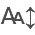

count    511.000000
mean      42.410802
std      101.701842
min        0.000000
25%        0.000000
50%        5.360000
75%       30.750000
max      853.110000
Name: NBA_2022, dtype: float64

In [176]:
init_notebook_mode(all_interactive=False)
gdf['NBA_2022'].describe()

In [177]:
# Save the GeoDataFrame to a GeoPackage file
gdf.to_file("pdt/asthma_mortality/data/gpkg/tma_pm25_ba_2001_2022.gpkg", driver="GPKG")

##### Remove temporal folders

In [178]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/downloads"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")


Folder 'pdt/asthma_mortality/data/raster/Fire_cci/downloads' removed successfully.


In [179]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/extracted"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")

Folder 'pdt/asthma_mortality/data/raster/Fire_cci/extracted' removed successfully.


In [180]:
folder_to_remove = "pdt/asthma_mortality/data/raster/Fire_cci/processed"

if os.path.exists(folder_to_remove):
    try:
        shutil.rmtree(folder_to_remove)
        print(f"Folder '{folder_to_remove}' removed successfully.")
    except OSError as e:
        print(f"Error removing folder '{folder_to_remove}': {e}")
else:
    print(f"Folder '{folder_to_remove}' does not exist.")

Folder 'pdt/asthma_mortality/data/raster/Fire_cci/processed' removed successfully.


## 📚 References

1. Lizundia-Loiola J, Otón G, Ramo R, Chuvieco E. A spatio-temporal active-fire clustering approach for global burned area mapping at 250 m from MODIS data. Remote Sensing of Environment. 2020;236:111493. doi:10.1016/j.rse.2019.111493

